<a href="https://colab.research.google.com/github/maura-gmu/geo_eviction/blob/main/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import sys
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from multiprocessing import Pool
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.neighbors import KernelDensity


# Increase recursion limit
sys.setrecursionlimit(10000)
# Read in raw Week 13 Housing Pulse Survey data
hps_df = pd.read_csv('/content/drive/MyDrive/data/pulse2020_puf_13.csv')
# See data columns
print(hps_df.columns)

Index(['SCRAM', 'WEEK', 'EST_ST', 'EST_MSA', 'REGION', 'HWEIGHT', 'PWEIGHT',
       'TBIRTH_YEAR', 'ABIRTH_YEAR', 'EGENDER',
       ...
       'PSWHYCHG1', 'PSWHYCHG2', 'PSWHYCHG3', 'PSWHYCHG4', 'PSWHYCHG5',
       'PSWHYCHG6', 'PSWHYCHG7', 'PSWHYCHG8', 'PSWHYCHG9', 'INCOME'],
      dtype='object', length=188)


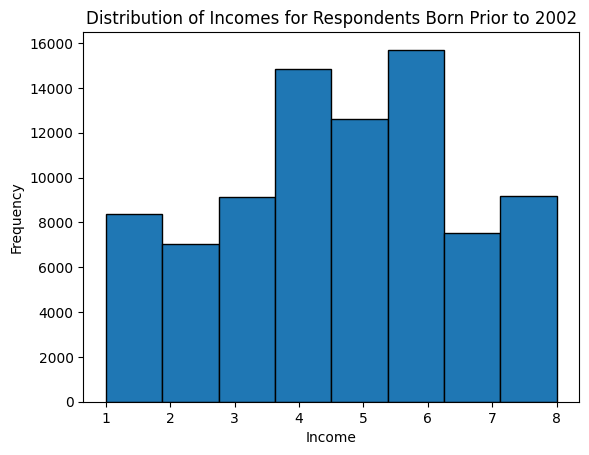

In [7]:
# Survey data is imputed with -88 and -99 for NAs
filtered_income = hps_df[~hps_df['INCOME'].isin([-88, -99])]['INCOME']

# Filter out income NAs (-88 and -99)
#filtered_income = filtered_income[filtered_income['EST_ST'] == '11']

# Plot the distribution of incomes using a histogram
plt.hist(filtered_income, bins=8, edgecolor='black')

# Add labels and title
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Distribution of Incomes for Respondents Born Prior to 2002') # all respondents are adults

# Show the plot
plt.show()
## Use this for income samples

# Filter to only include DC incomes
#filtered_income = filtered_income[filtered_income['EST_ST'] == '11']
#plt.show()


In [11]:
##### Data Imputation for missing response data #############################

## SCRAM can be removed
## TSPNDFOOD, TSPNDPRPD TBIRTH_YEAR are integers
## Week is time, but constant, so can remove
## HWEIGHT, PWEIGHT are floats
## INCOME is ordinal
## everything else is factor

# Columns to exclude from being converted to factors
non_factors = ['WEEK', 'TBIRTH_YEAR', 'HWEIGHT', 'PWEIGHT', 'TSPNDFOOD', 'TSPNDPRPD']

# Convert the rest to factors
hps_df_2 = hps_df.astype({col: 'object' for col in hps_df.columns if col not in non_factors})

# Define columns to encode
ord_columns = ['INCOME']
cat_columns = [
    "WRKLOSS", "ANYWORK","EXPCTLOSS","TENURE",
    "LIVQTR","RENTCUR","MORTCUR","EVICT","FORCLOSE","SPNDSRC2",
]
int_columns = ["TSPNDFOOD", "TSPNDPRPD"]

# Replace values in all specified columns
hps_df_2.replace({-88: np.nan, -99: np.nan}, inplace=True)
# Replace inconsistent NA values with np.nan
hps_df_2.replace({'pd\.NA|None|null|na': np.nan}, regex=True, inplace=True)

pd.options.display.max_columns = None

# TENURE refers to the type of housing
hps_df_2.loc[hps_df_2['TENURE'] != 3, 'RENTCUR'] = 77 # question is irrelevant to non-renters and shouldn't be imputed under that condition
hps_df_2.loc[hps_df_2['TENURE'] != 2, 'MORTCUR'] = 77 # question is irrelevant to non-owners and shouldn't be imputed under that condition
hps_df_2.loc[(hps_df_2['TENURE'] != 3) & (hps_df_2['RENTCUR'] != 2), 'EVICT'] = 77 # question is irrelevant to non-renters and renters that are caught up on rent
hps_df_2.loc[(hps_df_2['TENURE'] != 2) & (hps_df_2['MORTCUR'] != 2), 'FORCLOSE'] = 77 # question is irrelevant to non-owners and owners that are caught up on mortgage

pd.options.display.max_columns = None
missing_values_mean = hps_df_2[cat_columns + ord_columns + int_columns].isnull().mean()
print(f"Prior to imputation:")
print(missing_values_mean)


Prior to imputation:
WRKLOSS      0.005429
ANYWORK      0.005961
EXPCTLOSS    0.006969
TENURE       0.178843
LIVQTR       0.182529
RENTCUR      0.000679
MORTCUR      0.001476
EVICT        0.177412
FORCLOSE     0.381152
SPNDSRC2     0.761167
INCOME       0.225784
TSPNDFOOD    0.175441
TSPNDPRPD    0.180952
dtype: float64


In [12]:
# Handle the missing data through imputaton
# Define the preprocessor to use

# Choose between iterative and knn imputation approaches for the non ordinal data
iterative_preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'), cat_columns),
        ('iterative_imputer', IterativeImputer(), cat_columns + int_columns + ord_columns),
    ],
    remainder='passthrough'
)

knn_preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'), cat_columns),
        ('knn_imputer', KNNImputer(n_neighbors=5, weights='distance'), int_columns + cat_columns),
        ('iterative_imputer', IterativeImputer(), ord_columns),
    ],
    remainder='passthrough'
)

def process_chunk(chunk):
    # Fit and transform the preprocessor on the chunk
    transformed_chunk = preprocessor.fit_transform(chunk)
    # Convert the transformed chunk into a DataFrame
    transformed_df = pd.DataFrame(transformed_chunk, columns=preprocessor.get_feature_names_out())
    return transformed_df

# Remove one-hot-encoded columns after inverse transformation
def remove_columns(df):
    return df.drop(columns=[col for col in df.columns if 'one_hot' in col])

# Inverse transform one-hot-encoded columns
def inverse_transform(df):
    # Get column names
    one_hot_columns = [col for col in df.columns if 'one_hot' in col]
    # Inverse transform columns
    inverse_df = df.copy()
    for col in one_hot_columns:
        inverse_df[col] = inverse_df[col].astype(int)  # Convert to integer
    return inverse_df

# Parallel processing
def process_chunk_with_inverse_and_removal(chunk):
    # Preprocess the chunk
    transformed_chunk = process_chunk(chunk)
    # Inverse transform  columns
    inverse_transformed_chunk = inverse_transform(transformed_chunk)
    # Remove one-hot-encoded columns
    cleaned_chunk = remove_columns(inverse_transformed_chunk)
    return cleaned_chunk

# Split HPS data into chunks
chunk_size = 1000
chunks = [hps_df_2[i:i+chunk_size].reset_index(drop=True) for i in range(0, len(hps_df_2), chunk_size)]

# Perform preprocessing
preprocessor = knn_preprocessor
with Pool() as pool:
    knn_results = list(tqdm(pool.imap(process_chunk_with_inverse_and_removal, chunks), total=len(chunks), desc="Processing knn chunks"))
preprocessor = iterative_preprocessor
with Pool() as pool:
    iterative_results = list(tqdm(pool.imap(process_chunk_with_inverse_and_removal, chunks), total=len(chunks), desc="Processing iterative chunks"))

hps_df_knn = pd.concat(knn_results, ignore_index=True)
hps_df_knn = hps_df_knn.rename(columns=lambda x: x.replace("knn_imputer__", ""))
hps_df_knn = hps_df_knn.rename(columns=lambda x: x.replace("remainder__", ""))
hps_df_knn = hps_df_knn.rename(columns=lambda x: x.replace("iterative_imputer__", ""))



hps_df_iterative = pd.concat(iterative_results, ignore_index=True)
hps_df_iterative = hps_df_iterative.rename(columns=lambda x: x.replace("iterative_imputer__", ""))
hps_df_iterative = hps_df_iterative.rename(columns=lambda x: x.replace("remainder__", ""))


Processing iterative chunks: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]


In [13]:
# Round imputed Income values back to whole numbers (buckets)

hps_df_knn['INCOME'] = pd.to_numeric(hps_df_knn['INCOME'], errors='coerce')
hps_df_knn['INCOME'] = np.round(hps_df_knn['INCOME'])

hps_df_iterative['INCOME'] = pd.to_numeric(hps_df_iterative['INCOME'], errors='coerce')
hps_df_iterative['INCOME'] = np.round(hps_df_iterative['INCOME'])

original_income_data = hps_df_2['INCOME']  # Original income data
imputed_income_knn = hps_df_knn['INCOME']  # Imputed income data after KNN imputation
imputed_income_iterative = hps_df_iterative['INCOME'] # Imputed income data after Iterative imputation

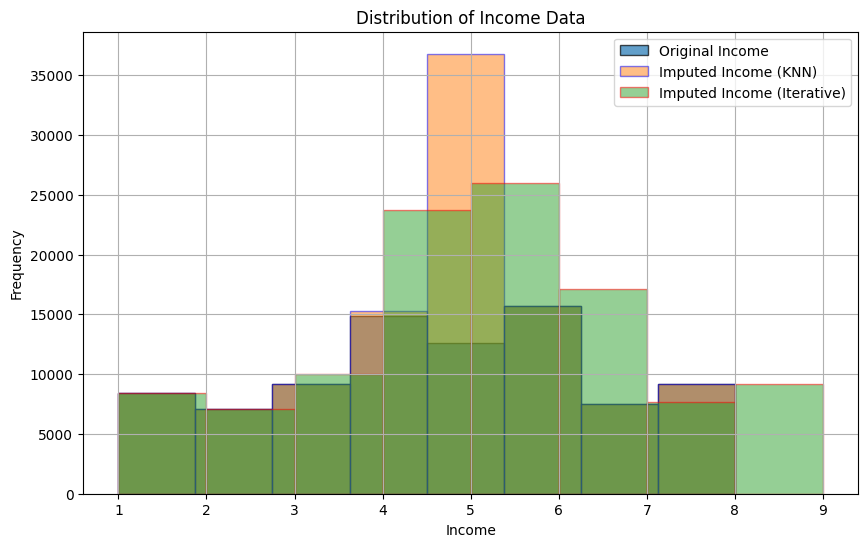

NameError: name 'stats' is not defined

In [14]:
# Display original and imputed income data
plt.figure(figsize=(10, 6))
plt.hist(original_income_data, bins=8, edgecolor='black', alpha=0.7, label='Original Income')
plt.hist(imputed_income_knn, bins=8, edgecolor='blue', alpha=0.5, label='Imputed Income (KNN)')
plt.hist(imputed_income_iterative, bins=8, edgecolor='red', alpha=0.5, label='Imputed Income (Iterative)')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Distribution of Income Data')
plt.legend()
plt.grid(True)
plt.show()

# Compare approaches
ks_stat_knn, ks_p_value_knn = stats.ks_2samp(original_income_data, imputed_income_knn)
ks_stat_iterative, ks_p_value_iterative = stats.ks_2samp(original_income_data, imputed_income_iterative)
alpha = 0.05  # Significance level
print('KS results:')
print(f'KNN Imputation: KS statistic = {ks_stat_knn}, p-value = {ks_p_value_knn}')
if ks_p_value_knn > alpha:
    print("Fail to reject the null.")

else:
    print("Reject the null.")
print(f'Iterative Imputation: KS statistic = {ks_stat_iterative}, p-value = {ks_p_value_iterative}')
if ks_p_value_iterative > alpha:
    print("Fail to reject the null.")
else:
    print("Reject the null.")

In [ ]:
# Compare income imputation to other approaches:
# Fitting to a distribution and KDE

In [18]:
# HPS income ranges for INCOME
income_table = {
    1: [0, 24999],
    2: [25000, 34999],
    3: [35000, 49999],
    4: [50000, 74999],
    5: [75000, 99999],
    6: [100000, 149999],
    7: [150000, 199999],
    8: [200000, np.nan]  # Upper bound is infinite
}


Reject the null.
Reject the null.
Reject the null.
Reject the null.


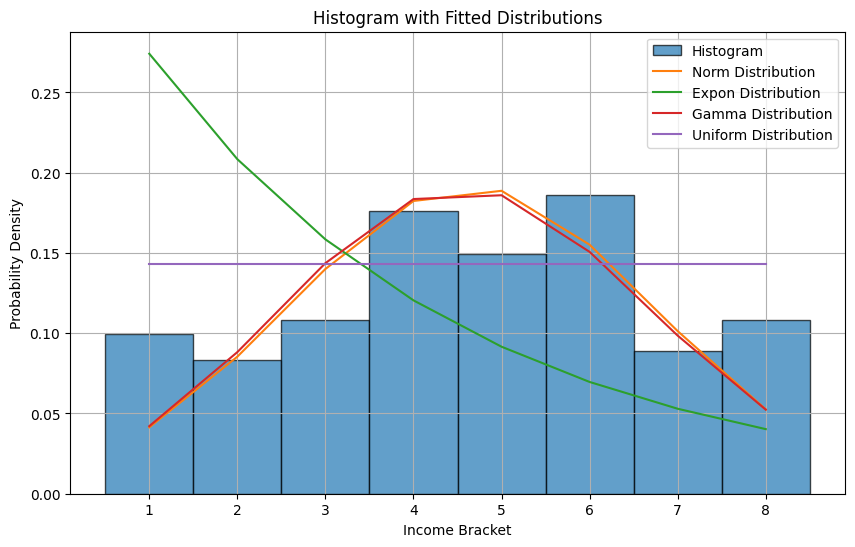

In [16]:
from scipy import stats
# Extract income data from the DataFrame
data = pd.Series(hps_df_2["INCOME"]).dropna()

distributions = ['norm', 'expon', 'gamma','uniform']
alpha = 0.05  # Significance level
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=np.arange(0.5, 9.5), edgecolor='black', alpha=0.7, density=True, label='Histogram')
for dist_name in distributions:
    # Fit the distribution to the income data
    dist_params = getattr(stats, dist_name).fit(data)

    # Generate the fitted distribution values
    x = np.arange(1, 9)
    fitted_dist = getattr(stats, dist_name).pdf(x, *dist_params)
    ks_stat, ks_p_value = stats.kstest(data, dist_name, args=dist_params)
    if ks_p_value > alpha:
      print("Fail to reject the null.")
    else:
        print("Reject the null.")
    # Plot the fitted distribution
    plt.plot(x, fitted_dist, label=f'{dist_name.capitalize()} Distribution')

# Add labels and legend
plt.title('Histogram with Fitted Distributions')
plt.xlabel('Income Bracket')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

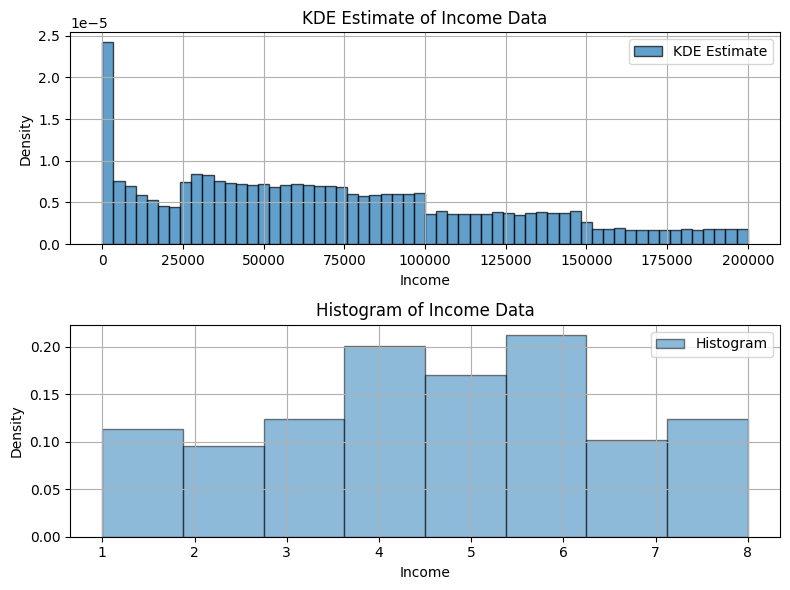

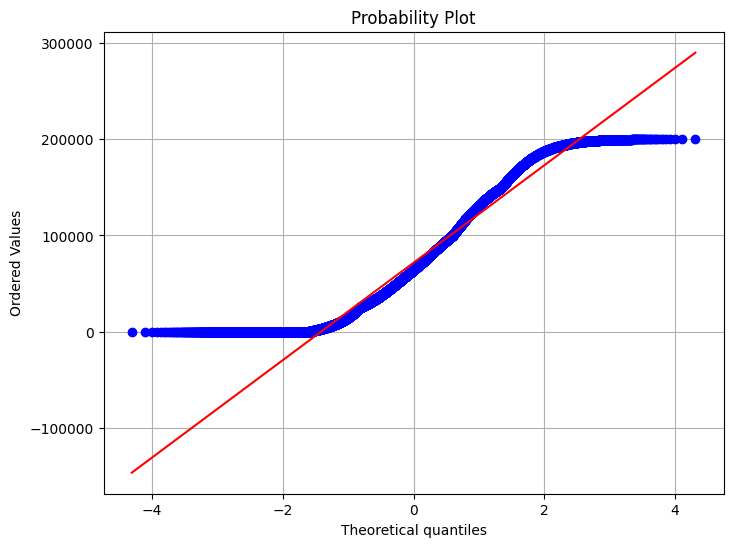

Distribution: KDE Estimate
KS test statistic: 0.9451252935409801, p-value: 0.0
Reject the null.


In [19]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Fit a Kernel Density Estimation (KDE) to the income data
kde = KernelDensity(bandwidth=10000)
data = pd.Series(hps_df_2["INCOME"]).dropna()

kde.fit(np.array(data).reshape(-1, 1))

def map_bracket_to_income(bracket):
    lower_bound, upper_bound = income_table[int(bracket)]
    if np.isnan(upper_bound):  # Check if upper bound is NaN
        # Use the CDF of the KDE to generate samples
        return kde.sample(1)[0][0]  # Sample from the KDE
    else:
        # Sample from a uniform distribution within the income bracket
        return np.random.uniform(lower_bound, upper_bound)

# Generate samples from the KDE
samples = [max(map_bracket_to_income(bracket), 0) for bracket in data]
# Set the figsize parameter for both plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot histogram
ax1.hist(samples, bins='auto', edgecolor='black', alpha=0.7, density=True, label='KDE Estimate')
ax1.set_title('KDE Estimate of Income Data')
ax1.set_xlabel('Income')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True)

# Plot KDE estimate
ax2.hist(data, bins=8, edgecolor='black', alpha=0.5, density=True, label='Histogram')
ax2.set_title('Histogram of Income Data')
ax2.set_xlabel('Income')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

# QQ Plot
plt.figure(figsize=(8, 6))
plt.title('Quantile-Quantile (QQ) Plot for KDE Estimate')
stats.probplot(samples, dist='norm', plot=plt)  # QQ plot against normal distribution for comparison
plt.grid(True)
plt.show()

# Calculate the KS test statistic and p-value
ks_stat, ks_p_value = stats.kstest(samples, 'norm', args=(), alternative='two-sided')

# Print the KS test results
print('Distribution: KDE Estimate')
print(f'KS test statistic: {ks_stat}, p-value: {ks_p_value}')

# Interpret the results
alpha = 0.05  # Significance level
if ks_p_value > alpha:
    print("Fail to reject the null.")
else:
    print("Reject the null.")


In [21]:
# Replace income column with continuous values sampled from KDE
def replace_income_with_continuous(row):
    if pd.isnull(row['INCOME']) or row['INCOME'] in income_table:
        # Sample from the KDE model for missing and bucketed values
        imputed_income = kde.sample(1)  # Sample from KDE model
        imputed_income = imputed_income[0][0]  # Extract the sampled value
        return imputed_income
    else:
        return row['INCOME']

# Apply the function to replace bucketed and missing income values
hps_df_2['income_kde'] = hps_df_2.apply(replace_income_with_continuous, axis=1)


In [26]:
# Choose which result to use for model:


In [27]:
# Rename columns
hps_df_processed = hps_df_2.rename(columns={'WRKLOSS': 'unemployed',
                                      'EEDUC': 'education_level',
                                      'RHISPANIC': 'latino',
                                      'RRACE': 'race',
                                      'TSPNDFOOD': 'home_food_costs',
                                      'TSPNDPRPD': 'outside_food_costs',
                                      'TENURE': 'housing_status',
                                      'RENTCUR': 'owe_backrent',
                                      'MORTCUR': 'owe_backmortgage',
                                      'EVICT': 'expect_eviction',
                                      'FORCLOSE': 'expect_foreclosure',
                                      'INCOME': 'income_bracket',
                                      'SPNDSRC2': 'use_credit_cards',
                                      'HWEIGHT': 'weight'})
# Drop unnecessary coluns
hps_df_processed = hps_df_processed[['unemployed', 'ANYWORK','education_level',
                'latino','race','home_food_costs','outside_food_costs','housing_status','LIVQTR',
                'owe_backrent','owe_backmortgage','expect_eviction','income_bracket',
                'expect_foreclosure','use_credit_cards','weight', 'EST_ST']]



In [36]:
# Filter to only include DC-level respondents
hps_df_dc = hps_df_processed[hps_df_processed['EST_ST'] == 11].copy()  # Filter for DC
hps_df_dc.to_csv('/content/drive/MyDrive/data/hps_df_filtered_MARCH2024.csv', index=False)